In [19]:
import pickle
import torch
from torch import linalg as LA
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from models import IrisClassifier
NUM_OF_MODELS = 500

device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.33
)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train, device=device, dtype=torch.float32),
    torch.tensor(X_test, device=device, dtype=torch.float32),
    torch.tensor(y_train, device=device, dtype=torch.long),
    torch.tensor(y_test, device=device, dtype=torch.long),
)

In [21]:
with open('real_matrix_list.pickle', 'rb') as f:
    real_matrices= pickle.load(f)
with open('scrambled_matrix_list.pickle', 'rb') as f:
    scrambled_matrices= pickle.load(f)
with open('generated_matrix_list.pickle', 'rb') as f:
    generated_matrices= pickle.load(f)

In [22]:
real_state_dicts = []
for matrix in real_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    real_state_dicts.append(state_dict)
scrambled_state_dicts = []
for matrix in scrambled_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1]  
    state_dict = {"linear.weight": W, "linear.bias": b}
    scrambled_state_dicts.append(state_dict)
generated_state_dicts = []
for matrix in generated_matrices:
    W = matrix[:, :-1]  
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    generated_state_dicts.append(state_dict)

In [23]:
real_plot = real_matrices[0:-1:20]
scrambled_plot = scrambled_matrices[0:-1:20]
generated_plot = generated_matrices[0:-1:20]
num_of_objects = len(real_plot)

In [24]:
def metric(A, B):
    return LA.matrix_norm((A - B), ord=2).item()

distances_real_real = []
distances_scrambled_scrambled = []
distances_generated_generated = []
for i in range(num_of_objects):
    for j in range(i + 1, num_of_objects):
        d_r_r = metric(real_plot[i], real_plot[j])
        d_s_s = metric(scrambled_plot[i], scrambled_plot[j])
        d_g_g = metric(generated_plot[i], generated_plot[j])
        distances_real_real.append(d_r_r)
        distances_scrambled_scrambled.append(d_s_s)
        distances_generated_generated.append(d_g_g)

distances_real_scrambled = []
distances_real_generated = []
distances_scrambled_generated = []
for r in real_plot:
    for s in scrambled_plot:
        d_r_s = metric(r, s)
        distances_real_scrambled.append(d_r_s)

for r in real_plot:
    for g in generated_plot:
        d_r_g = metric(r,g)
        distances_real_generated.append(d_r_g)

for s in scrambled_plot:
        for g in generated_plot:
            d_s_g = metric(s, g)
            distances_scrambled_generated.append(d_s_g)


In [25]:
def reshape_to_matrix(distances_list):
    matrix = np.zeros((num_of_objects, num_of_objects))
    index = 0
    for i in range(num_of_objects):
        for j in range(i + 1, num_of_objects):
            matrix[i][j] = distances_list[index]
            matrix[j][i] = distances_list[index]
            index += 1
    return matrix
real_real_matrix = reshape_to_matrix(distances_real_real)
scrambled_scrambled_matrix = reshape_to_matrix(distances_scrambled_scrambled)
generated_generated_matrix = reshape_to_matrix(distances_generated_generated)
real_scrambled_matrix = np.reshape(
    distances_real_scrambled, (num_of_objects, num_of_objects)
)
real_generated_matrix = np.reshape(
    distances_real_generated, (num_of_objects, num_of_objects)
)
scrambled_generated_matrix = np.reshape(
    distances_scrambled_generated, (num_of_objects, num_of_objects)
)

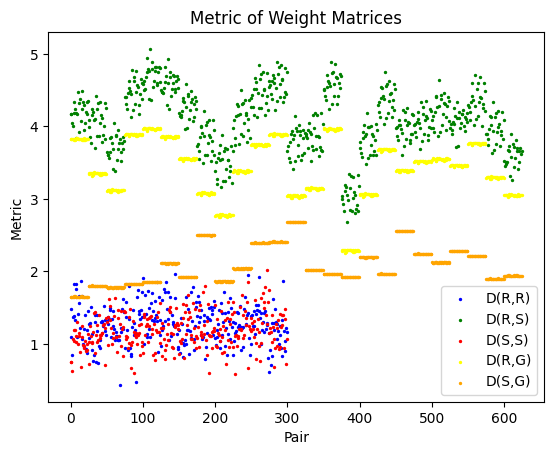

In [26]:
plt.scatter(
    range(len(distances_real_real)),
    distances_real_real,
    color="blue",
    label="D(R,R)",
    s=2,
)
plt.scatter(
    range(len(distances_real_scrambled)),
    distances_real_scrambled,
    color="green",
    label="D(R,S)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_scrambled)),
    distances_scrambled_scrambled,
    color="red",
    label="D(S,S)",
    s=2,
)
plt.scatter(
    range(len(distances_real_generated)),
    distances_real_generated,
    color="yellow",
    label="D(R,G)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_generated)),
    distances_scrambled_generated,
    color="orange",
    label="D(S,G)",
    s=2,
)
plt.xlabel("Pair")
plt.ylabel("Metric")
plt.legend()
plt.title("Metric of Weight Matrices")
plt.show()

In [27]:
upper_left_block = real_real_matrix
upper_middle_block = real_scrambled_matrix
middle_left_block = real_scrambled_matrix.T
middle_middle_block = scrambled_scrambled_matrix
upper_right_block = real_generated_matrix
middle_right_block = scrambled_generated_matrix
lower_right_block = generated_generated_matrix
lower_middle_block = scrambled_generated_matrix.T
lower_left_block = real_generated_matrix.T


distances_matrix = np.block(
    [
        [upper_left_block, upper_middle_block, upper_right_block],
        [middle_left_block, middle_middle_block, middle_right_block],
        [lower_left_block, lower_middle_block, lower_right_block],
    ]
)

perplexity = min(15, 2 * num_of_objects - 1)
tsne = TSNE(n_components=2, perplexity=perplexity)
embedded_distances_matrix = tsne.fit_transform(distances_matrix)
embedded_real = embedded_distances_matrix[:num_of_objects]
embedded_scrambled = embedded_distances_matrix[num_of_objects : 2 * num_of_objects]
embedded_generated = embedded_distances_matrix[2 * num_of_objects :]

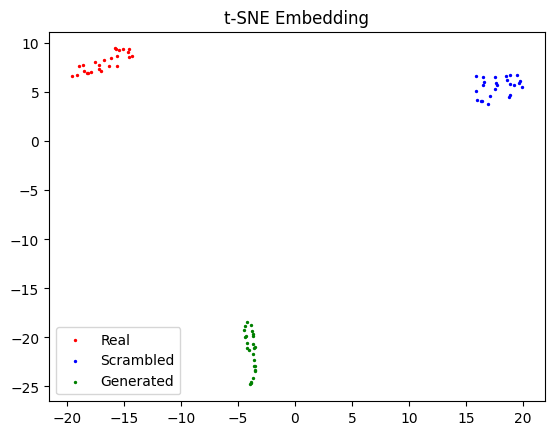

In [28]:
plt.scatter(embedded_real[:, 0], embedded_real[:, 1], color="red", label="Real", s=2)
plt.scatter(embedded_scrambled[:, 0], embedded_scrambled[:, 1], color="blue", label="Scrambled", s=2)
plt.scatter(embedded_generated[:, 0], embedded_generated[:, 1], color="green", label="Generated", s=2)

plt.title("t-SNE Embedding")
plt.legend()
plt.title("t-SNE Embedding")
plt.show()

In [29]:
diagonal_real = []
diagonal_scrambled = []
diagonal_generated = []

for state_dict in real_state_dicts:
    model = IrisClassifier().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_real.append(diagonal / len(y_test))

for state_dict in scrambled_state_dicts:
    model = IrisClassifier().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_scrambled.append(diagonal / len(y_test))

for state_dict in generated_state_dicts:
    model = IrisClassifier().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_generated.append(diagonal / len(y_test))

print("Diag(R): {:.4f}".format(np.mean(diagonal_real)))
print("Diag(S): {:.4f}".format(np.mean(diagonal_scrambled)))
print("Diag(G): {:.4f}".format(np.mean(diagonal_generated)))

Diag(R): 0.9768
Diag(S): 0.3426
Diag(G): 0.9797
